In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
%matplotlib inline

In [2]:
args = {
    'noise':0.01,
    'train size':0.7,
    'spec scale':10**12,
    'scaler':RobustScaler(),
    }

param_grid = {
    'module__num_hidden' : [2, 4, 6, 8],
    'optimizer' : [torch.optim.Rprop],
    'optimizer__lr' : [0.01],
    'max_epochs' : [5000],
    'module__start_size':[15, 30, 45]
}

In [3]:
df = pd.read_excel('data_3nm.xlsx')

In [4]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [5]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [6]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [7]:
# add noise
X_noisy = add_noise(X, args['noise'])

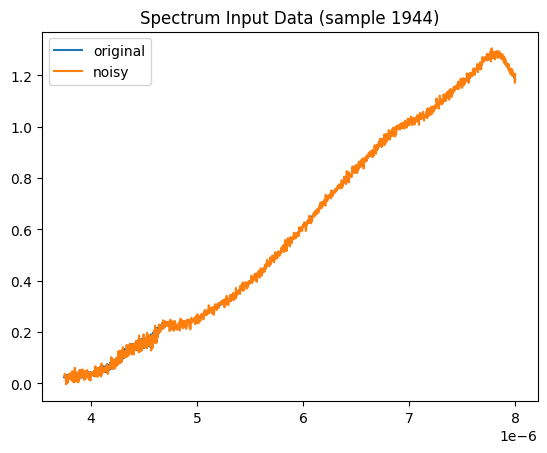

In [8]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [9]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [10]:
X_tensor = torch.tensor(X_noisy_scaled_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden, start_size):
        super(Net, self).__init__()
        
        hidden_sizes = [input_size]
        step = start_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(start_size - (i+1) * step)
            if hidden_size < 11: hidden_size = 11
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [12]:
input_size = len(X.columns)
output_size = len(y.columns)

In [ ]:
net = NeuralNetRegressor(
    module=Net,
    module__input_size=input_size,
    module__output_size=output_size,
    module__start_size=30,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

gs = GridSearchCV(net, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=3)

gs.fit(X_tensor, y_tensor)

best_model = gs.best_estimator_
best_params = gs.best_params_

print('Best loss: {}'.format(gs.best_score_))
print('Params: {}'.format(best_params))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    87044.6431    41271.2085  0.1049
      2    30231.0694    24864.0641  0.0747
      3    23201.8416    17160.5123  0.0486
      4    12372.3910     7742.4588  0.0417
      5     5283.1118     2654.5777  0.0492
      6     1751.6125     1001.1279  0.0496
      7      789.2841      697.2328  0.0499
      8      573.8251      508.5725  0.0494
      9      409.4271      387.6782  0.0410
     10      326.0035      314.7831  0.0490
     11      268.6571      259.9281  0.0413
     12      221.7610      201.8591  0.0409
     13      181.1465      182.6891  0.0741
     14      166.6696      170.0661  0.0896
     15      156.7479      160.3122  0.0746
     16      148.4399      152.2700  0.0834
     17      141.7784      145.0125  0.0770
     18      134.5156      136.2271  0.0730
     19      127.9069      130.5259  0.0696
     20      1

    274       57.3194       59.6003  0.0803
    275       57.3145       59.5953  0.0666
    276       57.3094       59.5901  0.0601
    277       57.3043       59.5848  0.0648
    278       57.2992       59.5794  0.0613
    279       57.2941       59.5741  0.0745
    280       57.2892       59.5689  0.0697
    281       57.2843       59.5636  0.0618
    282       57.2793       59.5581  0.0652
    283       57.2743       59.5527  0.0646
    284       57.2694       59.5473  0.0683
    285       57.2645       59.5420  0.0646
    286       57.2595       59.5367  0.0609
    287       57.2543       59.5308  0.0610
    288       57.2491       59.5252  0.0644
    289       57.2442       59.5200  0.0586
    290       57.2394       59.5150  0.0591
    291       57.2342       59.5098  0.0584
    292       57.2290       59.5047  0.0580
    293       57.2235       59.4995  0.0602
    294       57.2170       59.4936  0.0611
    295       57.2083       59.4876  0.0611
    296       57.1962       59.4